## Lab 4, Group 4
### Names: Hailey DeMark, Deborah Park, Karis Park
### Student IDs: 48869449, 48878679, 48563429

Link to DataSet: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data/data

## Load, Split, and Balance (1.5 points total)

* [.5 points] (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. (2) Remove any observations that having missing data. (3) Encode any string data as integers for now. (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [13]:
# Load Data 
file = 'data.csv'
df = pd.read_csv(file)

# remove missing rows
df.dropna(inplace=True)

# convert string to integer
categorical_columns = df.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# remove county
df = df.drop(columns=['County'])

# check
print("Shape of cleaned data:", df.shape)
print("Remaining columns:", df.columns.tolist())

Shape of cleaned data: (72718, 36)
Remaining columns: ['TractId', 'State', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment']


#### Discuss why you decided to keep/remove this variable. 
- We decided to drop the "county" variable from our dataset since it is a categorical identifier that we don't believe will significantly impact the model's performance. County has no order to its values, so including it could cause the model to overfit to specific counties rather than learning general patterns across the data. Since our goal is to predict the child poverty rate for each tract, there are other, more informative variables in the dataset that better support this task. County is also a more specific location indicator than State, which we are still using in our dataset. 


#### Should balancing of the dataset be done for both the training and testing set? Explain.
* Balancing of the dataset should only be done for the training set because we don't want to touch the testing set as much as possible. In a real-life scenario, we don't have access to the testing set, or future data, when training our model on the past data. So, we want to mimic these conditions as much as possible, leaving the testing data untouched until we're done training our model on the training data. 

In [14]:
# split features and target
y = df['ChildPoverty'].values
X = df.drop(columns=['ChildPoverty']).values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# split 'childpoverty' into 4 quantiles
quantiles = np.quantile(y_train, [0.25, 0.5, 0.75])

def quant_poverty(val):
    if val <= quantiles[0]:
        return 0
    elif val <= quantiles[1]:
        return 1
    elif val <= quantiles[2]:
        return 2
    else:
        return 3

# used Claude AI to apply the quantiles to the training data and one-hot-encode target arrays
# Apply the function to the numpy array
vectorized_quant = np.vectorize(quant_poverty)
y_train_classes = vectorized_quant(y_train)
y_test_classes = vectorized_quant(y_test)

# One-hot encode the targets
y_train_dummy = np.eye(4)[y_train_classes]
y_test_dummy = np.eye(4)[y_test_classes]

# Check class distribution
print("Quantile thresholds:", quantiles)
print("Class distribution in training set:")
unique, counts = np.unique(y_train_classes, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} instances")

(58174, 35) (14544, 35) (58174,) (14544,)
Quantile thresholds: [ 6.2 16.4 31.7]
Class distribution in training set:
Class 0: 14596 instances
Class 1: 14580 instances
Class 2: 14476 instances
Class 3: 14522 instances


## Pre-processing and Initial Modeling (2.5 points total)

You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

* [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

* [.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

* [.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

* [1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  
    * Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.
We chose a customer segmentation dataset with 8,068 entries. It includes details about customers, such as their gender, age, marital status, education, job, work experience, spending habits, and family size. The goal is to predict which of four customer groups (A, B, C, or D) a customer belongs to based on their information. This dataset would be helpful for businesses to understand their customers and target audience better. Additionally, companies can use the results to send personalized offers, improve customer service, and make better marketing plans. This model would be deployed mostly for online-use because it's important for companies to keep up with the trends and preferences of their target audience and general customers to make the right choices in marketing and keep up sales. 

In [15]:
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [16]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                
                
                # simple momentum calculations
                
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [17]:
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3+1e-7)+(1-Y_enc)*np.log(1-A3+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

In [18]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

In [19]:
# model accuracy before normalization  
model1 = TLPBetterInitial(epochs = 100, minibatches = int(len(X_train) / 256))

model1.fit(X_train, y_train_classes, True, (X_test, y_test_classes))

print(f"Training accuracy: { model1.score_[-1] }")
print(f"Testing accuracy: { model1.val_score_[-1] }")

Epoch: 100/100

Training accuracy: 0.2509024650187369
Testing accuracy: 0.24979372937293728


In [20]:
# normalize the data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [21]:
# model accuracy after normalization 
model2 = TLPBetterInitial(epochs = 100, minibatches = int(len(X_train) / 256))

model2.fit(X_train_norm, y_train_classes, True, (X_test_norm, y_test_classes))

print(f"Training accuracy: { model2.score_[-1] }")
print(f"Testing accuracy: { model2.val_score_[-1] }")

Epoch: 100/100

Training accuracy: 0.7144428782617664
Testing accuracy: 0.7091584158415841


In [22]:
from sklearn.preprocessing import OneHotEncoder
# one hot encoding the state variable (our only categorical column since we dropped county)
ohe = OneHotEncoder()

state_ohe_train = ohe.fit_transform(X_train[:,1].reshape(-1, 1)).toarray()
state_ohe_test = ohe.transform(X_test[:,1].reshape(-1, 1)).toarray()

X_train_ohe = np.delete(X_train_norm, 1, axis = 1)
X_test_ohe = np.delete(X_test_norm, 1, axis = 1)

X_train_ohe = np.column_stack((X_train_ohe, state_ohe_train))
X_test_ohe = np.column_stack((X_test_ohe, state_ohe_test))

In [23]:
# model accuracy after normalizing and one hot encoding 
model3 = TLPBetterInitial(epochs = 100, minibatches = int(len(X_train) / 256))

model3.fit(X_train_ohe, y_train_classes, True, (X_test_ohe, y_test_classes))

print(f"Training accuracy: { model3.score_[-1] }")
print(f"Testing accuracy: { model3.val_score_[-1] }")

Epoch: 100/100

Training accuracy: 0.7216797882215422
Testing accuracy: 0.7170654565456546


## Modeling (5 points total)

* [1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
    * Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

* [1 points] Repeat the previous step, adding support for a fourth layer.

* [1 points] Repeat the previous step, adding support for a fifth layer. 

* [2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

#### Three Layer Model

In [24]:
class ThreeLayerPerceptron(TLPBetterInitial):
    def __init__(self, n_hidden_2 = 30, **kwds):
        self.n_hidden_2 = n_hidden_2

        # but keep other keywords
        super().__init__(**kwds)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden_2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_2)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3
  
    def _cost(self,A4,Y_enc,W1,W2,W3):
      '''Get the objective function value'''
      cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4+1e-7)+(1-Y_enc)*np.log(1-A4+1e-7))))
      L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
      return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
      """ Compute gradient step using backpropagation.
      """
      # vectorized backpropagation
      V3 = (A4-Y_enc) # <- this is only line that changed
      V2 = A3*(1-A3)*(W3.T @ V3)
      V1 = A2*(1-A2)*(W2.T @ V2)
      
      gradW3 = V3 @ A3.T
      gradW2 = V2 @ A2.T
      gradW1 = V1 @ A1.T
      
      gradb3 = np.sum(V3, axis=1).reshape((-1,1))
      gradb2 = np.sum(V2, axis=1).reshape((-1,1))
      gradb1 = np.sum(V1, axis=1).reshape((-1,1))
      
      # regularize weights that are not bias terms
      gradW1 += W1 * self.l2_C
      gradW2 += W2 * self.l2_C
      gradW3 += W3 * self.l2_C

      return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred
  
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum

        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            grad_w1_ = []
            grad_w2_ = []
            grad_w3_ = []
            
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3
                                                      )
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3)

                
                # store gradients
                grad_w1_.append(gradW1)
                grad_w2_.append(gradW2)
                grad_w3_.append(gradW3)


                # simple momentum calculations
                
                rho_W1, rho_W2, rho_W3 = eta * gradW1, eta * gradW2, eta * gradW3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))

            self.grad_w1_.append(np.mean(np.abs(grad_w1_)))
            self.grad_w2_.append(np.mean(np.abs(grad_w2_)))
            self.grad_w3_.append(np.mean(np.abs(grad_w3_)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [25]:
model4 = ThreeLayerPerceptron(
  epochs = 100, 
  n_hidden_2=25,
  minibatches = int(len(X_train) / 256)
)

model4.fit(X_train_ohe, y_train_classes, True, (X_test_ohe, y_test_classes))

print(f"Training accuracy: { model4.score_[-1] }")
print(f"Testing accuracy: { model4.val_score_[-1] }")

Epoch: 100/100

Training accuracy: 0.7259428610719565
Testing accuracy: 0.7246974697469747


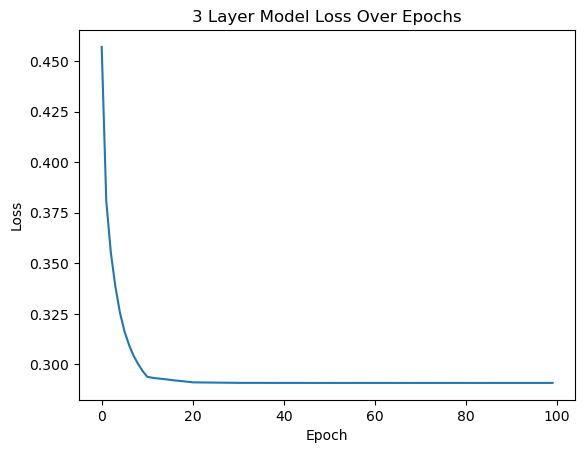

In [26]:
# plotting the cost of the model with three layers 
plt.plot(model4.cost_)

plt.title("3 Layer Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

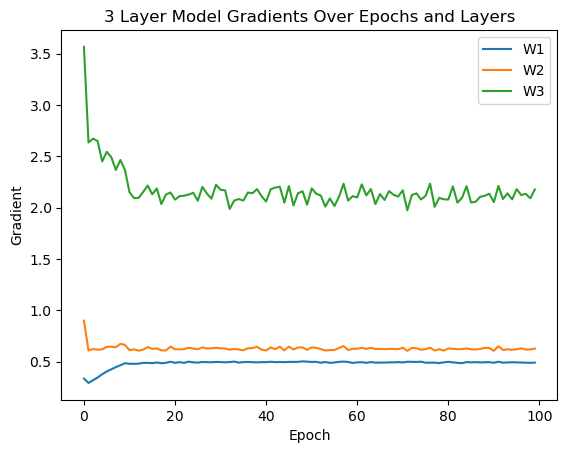

In [27]:
# plotting the 3 layer model showing gradients over epochs for each layer
plt.plot(model4.grad_w1_, label = "W1")
plt.plot(model4.grad_w2_, label = "W2")
plt.plot(model4.grad_w3_, label = "W3")

plt.title("3 Layer Model Gradients Over Epochs and Layers")
plt.xlabel("Epoch")
plt.ylabel("Gradient")
plt.legend()

plt.show()

#### Four Layer Model

In [28]:
class FourLayerPerceptron(ThreeLayerPerceptron):
    def __init__(self, n_hidden_3 = 30, **kwds):
        self.n_hidden_3 = n_hidden_3

        # but keep other keywords
        super().__init__(**kwds)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden_2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden))

        init_bound = 4*np.sqrt(6. / (self.n_hidden_3 + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_3)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_hidden_3, 1))
        b4 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, b1, b2, b3, b4
  
    def _cost(self,A5,Y_enc,W1,W2,W3, W4):
      '''Get the objective function value'''
      cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5+1e-7)+(1-Y_enc)*np.log(1-A5+1e-7))))
      L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
      return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
      """ Compute gradient step using backpropagation.
      """
      # vectorized backpropagation
      V4 = (A5-Y_enc) # <- this is only line that changed
      V3 = A4*(1-A4)*(W4.T @ V4)
      V2 = A3*(1-A3)*(W3.T @ V3)
      V1 = A2*(1-A2)*(W2.T @ V2)
      
      gradW4 = V4 @ A4.T
      gradW3 = V3 @ A3.T
      gradW2 = V2 @ A2.T
      gradW1 = V1 @ A1.T
      
      gradb4 = np.sum(V4, axis=1).reshape((-1,1))
      gradb3 = np.sum(V3, axis=1).reshape((-1,1))
      gradb2 = np.sum(V2, axis=1).reshape((-1,1))
      gradb1 = np.sum(V1, axis=1).reshape((-1,1))
      
      # regularize weights that are not bias terms
      gradW1 += W1 * self.l2_C
      gradW2 += W2 * self.l2_C
      gradW3 += W3 * self.l2_C
      gradW4 += W4 * self.l2_C

      return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4
    
    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred
  
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum
        rho_W4_prev = np.zeros(self.W4.shape) # for momentum

        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []
        self.grad_w4_ = []
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            grad_w1_ = []
            grad_w2_ = []
            grad_w3_ = []
            grad_w4_ = []

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3, 
                                                       self.b4
                                                      )
                
                cost = self._cost(A5,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4)

                # store gradients
                grad_w1_.append(gradW1)
                grad_w2_.append(gradW2)
                grad_w3_.append(gradW3)
                grad_w4_.append(gradW4)              
                
                # simple momentum calculations
                
                rho_W1, rho_W2, rho_W3, rho_W4 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev = rho_W1, rho_W2, rho_W3, rho_W4
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            self.grad_w1_.append(np.mean(np.abs(grad_w1_)))
            self.grad_w2_.append(np.mean(np.abs(grad_w2_)))
            self.grad_w3_.append(np.mean(np.abs(grad_w3_)))
            self.grad_w4_.append(np.mean(np.abs(grad_w4_)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [29]:
# model accuracy with 4 layers 
model5 = FourLayerPerceptron(
  epochs = 100, 
  n_hidden_2=25,
  n_hidden_3=20,
  minibatches = int(len(X_train) / 256)
)

model5.fit(X_train_ohe, y_train_classes, True, (X_test_ohe, y_test_classes))

print(f"Training accuracy: { model5.score_[-1] }")
print(f"Testing accuracy: { model5.val_score_[-1] }")

Epoch: 100/100

Training accuracy: 0.7301887441124901
Testing accuracy: 0.7272414741474147


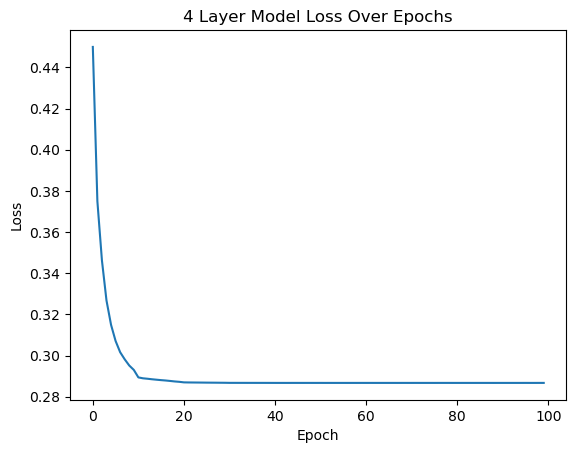

In [30]:
# plotting the model loss with 4 layers in model 
plt.plot(model5.cost_)

plt.title("4 Layer Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

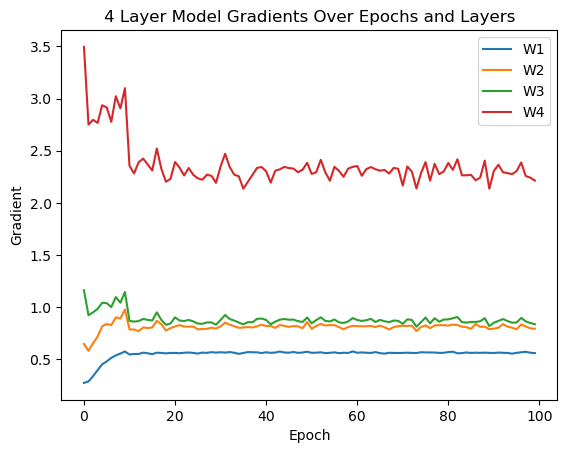

In [32]:
# plotting the 4 layer model showing gradients over epochs for each layer
plt.plot(model5.grad_w1_, label = "W1")
plt.plot(model5.grad_w2_, label = "W2")
plt.plot(model5.grad_w3_, label = "W3")
plt.plot(model5.grad_w4_, label = "W4")

plt.title("4 Layer Model Gradients Over Epochs and Layers")
plt.xlabel("Epoch")
plt.ylabel("Gradient")
plt.legend()

plt.show()

#### Five Layer Model

In [33]:
class FiveLayerPerceptron(FourLayerPerceptron):
    def __init__(self, n_hidden_4 = 30, **kwds):
        self.n_hidden_4 = n_hidden_4

        # but keep other keywords
        super().__init__(**kwds)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden_2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden))

        init_bound = 4*np.sqrt(6. / (self.n_hidden_3 + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2))

        init_bound = 4*np.sqrt(6. / (self.n_hidden_4 + self.n_hidden_3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_4, self.n_hidden_3))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_4)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_hidden_3, 1))
        b4 = np.zeros((self.n_hidden_4, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5 
  
    def _cost(self,A6,Y_enc,W1,W2,W3, W4, W5):
      '''Get the objective function value'''
      cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6+1e-7)+(1-Y_enc)*np.log(1-A6+1e-7))))
      L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
      return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
      """ Compute gradient step using backpropagation.
      """
      # vectorized backpropagation
      V5 = (A6-Y_enc) # <- this is only line that changed
      V4 = A5*(1-A5)*(W5.T @ V5)
      V3 = A4*(1-A4)*(W4.T @ V4)
      V2 = A3*(1-A3)*(W3.T @ V3)
      V1 = A2*(1-A2)*(W2.T @ V2)
      
      gradW5 = V5 @ A5.T
      gradW4 = V4 @ A4.T
      gradW3 = V3 @ A3.T
      gradW2 = V2 @ A2.T
      gradW1 = V1 @ A1.T
      
      gradb5 = np.sum(V5, axis=1).reshape((-1,1))
      gradb4 = np.sum(V4, axis=1).reshape((-1,1))
      gradb3 = np.sum(V3, axis=1).reshape((-1,1))
      gradb2 = np.sum(V2, axis=1).reshape((-1,1))
      gradb1 = np.sum(V1, axis=1).reshape((-1,1))
      
      # regularize weights that are not bias terms
      gradW1 += W1 * self.l2_C
      gradW2 += W2 * self.l2_C
      gradW3 += W3 * self.l2_C
      gradW4 += W4 * self.l2_C
      gradW5 += W5 * self.l2_C

      return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred
  
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum
        rho_W4_prev = np.zeros(self.W4.shape) # for momentum
        rho_W5_prev = np.zeros(self.W5.shape) # for momentum

        self.grad_w1_ = []
        self.grad_w2_ = []
        self.grad_w3_ = []
        self.grad_w4_ = []
        self.grad_w5_ = []
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            grad_w1_ = []
            grad_w2_ = []
            grad_w3_ = []
            grad_w4_ = []
            grad_w5_ = []

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3, 
                                                       self.b4, 
                                                       self.b5
                                                      )
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4, self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4, W5=self.W5)

                # store gradients
                grad_w1_.append(gradW1)
                grad_w2_.append(gradW2)
                grad_w3_.append(gradW3)
                grad_w4_.append(gradW4)
                grad_w5_.append(gradW5)
                
                # simple momentum calculations
                
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4, eta * gradW5
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            self.grad_w1_.append(np.mean(np.abs(grad_w1_)))
            self.grad_w2_.append(np.mean(np.abs(grad_w2_)))
            self.grad_w3_.append(np.mean(np.abs(grad_w3_)))
            self.grad_w4_.append(np.mean(np.abs(grad_w4_)))
            self.grad_w5_.append(np.mean(np.abs(grad_w5_)))
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [34]:
# showing accuracy of model with 5 layers 
model6 = FiveLayerPerceptron(
  epochs = 100, 
  n_hidden_2=25,
  n_hidden_3=20,
  n_hidden_4=15,
  minibatches = int(len(X_train) / 256)
)

model6.fit(X_train_ohe, y_train_classes, True, (X_test_ohe, y_test_classes))

print(f"Training accuracy: { model6.score_[-1] }")
print(f"Testing accuracy: { model6.val_score_[-1] }")

Epoch: 100/100

Training accuracy: 0.7313404613744972
Testing accuracy: 0.7277227722772277


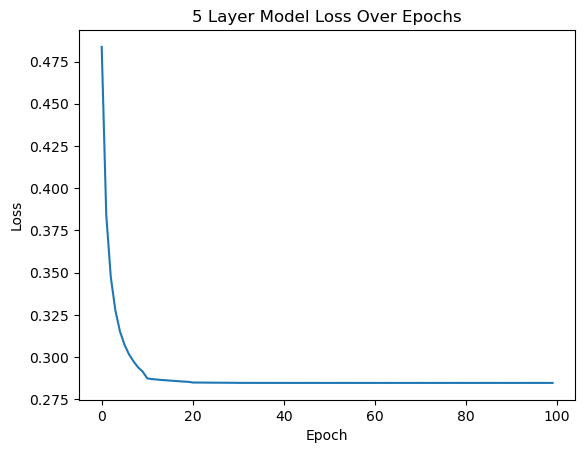

In [35]:
# graphing the model loss over epochs for 5 layer model 
plt.plot(model6.cost_)

plt.title("5 Layer Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

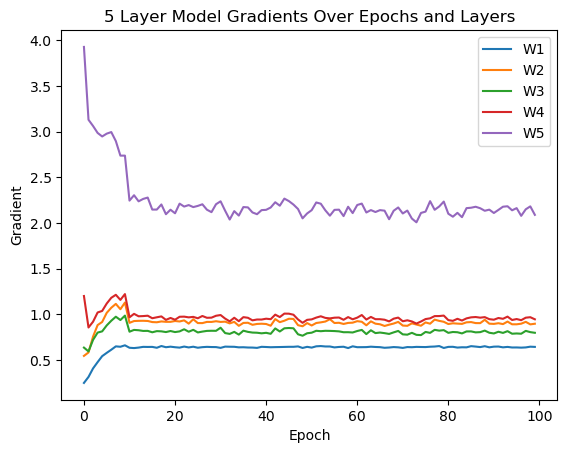

In [36]:
# plotting gradients over epochs for each of the 5 layers 
plt.plot(model6.grad_w1_, label = "W1")
plt.plot(model6.grad_w2_, label = "W2")
plt.plot(model6.grad_w3_, label = "W3")
plt.plot(model6.grad_w4_, label = "W4")
plt.plot(model6.grad_w5_, label = "W5")

plt.title("5 Layer Model Gradients Over Epochs and Layers")
plt.xlabel("Epoch")
plt.ylabel("Gradient")
plt.legend()

plt.show()

#### Implementing RMSProp as our Adaptive Learning Technique

In [37]:
class RMSPropPerceptron(FiveLayerPerceptron):
    def __init__(self, epsilon = 1e-7, **kwds):
        self.epsilon = epsilon

        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
            """ Learn weights from training data. With mini-batch"""
            X_data, y_data = X.copy(), y.copy()
            Y_enc = self._encode_labels(y)
            
            # init weights and setup matrices
            self.n_features_ = X_data.shape[1]
            self.n_output_ = Y_enc.shape[0]
            self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

            # start momentum at zero for previous updates
            rho_W1_prev = np.zeros(self.W1.shape) # for momentum
            rho_W2_prev = np.zeros(self.W2.shape) # for momentum
            rho_W3_prev = np.zeros(self.W3.shape) # for momentum
            rho_W4_prev = np.zeros(self.W4.shape) # for momentum
            rho_W5_prev = np.zeros(self.W5.shape) # for momentum

            V1_prev = np.zeros(self.W1.shape)
            V2_prev = np.zeros(self.W2.shape)
            V3_prev = np.zeros(self.W3.shape)
            V4_prev = np.zeros(self.W4.shape)
            V5_prev = np.zeros(self.W5.shape)

            self.grad_w1_ = []
            self.grad_w2_ = []
            self.grad_w3_ = []
            self.grad_w4_ = []
            self.grad_w5_ = []
            self.cost_ = []
            self.score_ = []
            # get starting acc
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            # keep track of validation, if given
            if XY_test is not None:
                X_test = XY_test[0].copy()
                y_test = XY_test[1].copy()
                self.val_score_ = []
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
                self.val_cost_ = []
                
            for i in range(self.epochs):

                # adaptive learning rate
                # decrease at certain epochs
                eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

                if print_progress>0 and (i+1)%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                    sys.stderr.flush()

                if self.shuffle:
                    idx_shuffle = np.random.permutation(y_data.shape[0])
                    X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

                grad_w1_ = []
                grad_w2_ = []
                grad_w3_ = []
                grad_w4_ = []
                grad_w5_ = []

                mini = np.array_split(range(y_data.shape[0]), self.minibatches)
                mini_cost = []
                for idx in mini:

                    # feedforward
                    A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                        self.W1,
                                                        self.W2,
                                                        self.W3,
                                                        self.W4,
                                                        self.W5,
                                                        self.b1,
                                                        self.b2,
                                                        self.b3, 
                                                        self.b4, 
                                                        self.b5
                                                        )
                    
                    cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4, self.W5)
                    mini_cost.append(cost) # this appends cost of mini-batch only

                    # compute gradient via backpropagation
                    gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                    Y_enc=Y_enc[:, idx],
                                                    W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4, W5=self.W5)
                    
                     # store gradients
                    grad_w1_.append(gradW1)
                    grad_w2_.append(gradW2)
                    grad_w3_.append(gradW3)
                    grad_w4_.append(gradW4)
                    grad_w5_.append(gradW5)
                    
                    
                    # simple momentum calculations

                    # RMSProp
                    G1 = gradW1 * gradW1
                    V1 = self.alpha * V1_prev + (1 - self.alpha) * G1

                    G2 = gradW2 * gradW2
                    V2 = self.alpha * V2_prev + (1 - self.alpha) * G2
                    
                    G3 = gradW3 * gradW3
                    V3 = self.alpha * V3_prev + (1 - self.alpha) * G3
                    
                    G4 = gradW4 * gradW4
                    V4 = self.alpha * V4_prev + (1 - self.alpha) * G4
                    
                    G5 = gradW5 * gradW5
                    V5 = self.alpha * V5_prev + (1 - self.alpha) * G5
                    
                    
                    rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * gradW1 / np.sqrt(V1 + self.epsilon), eta * gradW2 / np.sqrt(V2 + self.epsilon), eta * gradW3 / np.sqrt(V3 + self.epsilon), eta * gradW4 / np.sqrt(V4 + self.epsilon), eta * gradW5 / np.sqrt(V5 + self.epsilon)
                    self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                    self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                    self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                    self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum
                    self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # update with momentum
                    
                    # no need for momentum in bias 
                    # these values need to change abruptly and 
                    # do not influence sensitivity backward
                    self.b1 -= eta * gradb1
                    self.b2 -= eta * gradb2
                    self.b3 -= eta * gradb3
                    self.b4 -= eta * gradb4
                    self.b5 -= eta * gradb5
                    
                    # update previous parameters 
                    rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5
                    V1_prev, V2_prev, V3_prev, V4_prev, V5_prev = V1, V2, V3, V4, V5
                    
                    

                self.cost_.append(np.mean(mini_cost))
                self.score_.append(accuracy_score(y_data,self.predict(X_data)))

                self.grad_w1_.append(np.mean(np.abs(grad_w1_)))
                self.grad_w2_.append(np.mean(np.abs(grad_w2_)))
                self.grad_w3_.append(np.mean(np.abs(grad_w3_)))
                self.grad_w4_.append(np.mean(np.abs(grad_w4_)))
                self.grad_w5_.append(np.mean(np.abs(grad_w5_)))
                
                # update if a validation set was provided
                if XY_test is not None:
                    yhat = self.predict(X_test)
                    self.val_score_.append(accuracy_score(y_test,yhat))
                
            return self

In [38]:
model7 = RMSPropPerceptron(
  epochs = 100, 
  n_hidden_2=25,
  n_hidden_3=20,
  n_hidden_4=15,
  minibatches = int(len(X_train) / 256)
)

model7.fit(X_train_ohe, y_train_classes, True, (X_test_ohe, y_test_classes))

print(f"Training accuracy: { model7.score_[-1] }")
print(f"Testing accuracy: { model7.val_score_[-1] }")

Epoch: 100/100

Training accuracy: 0.7287276102726303
Testing accuracy: 0.7208470847084708


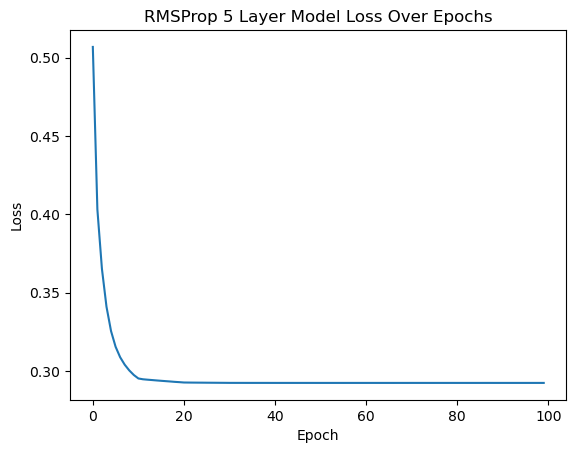

In [39]:
# plotting RMS Propagation of the 5 layer model
plt.plot(model7.cost_)

plt.title("RMSProp 5 Layer Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

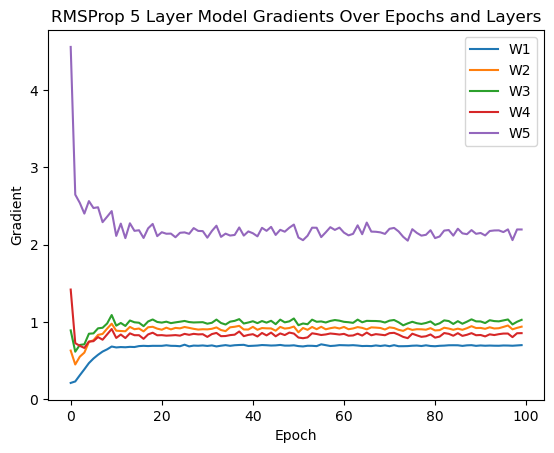

In [40]:
# graphing gradients of layers in the RMS propagation 5 layer model 
plt.plot(model7.grad_w1_, label = "W1")
plt.plot(model7.grad_w2_, label = "W2")
plt.plot(model7.grad_w3_, label = "W3")
plt.plot(model7.grad_w4_, label = "W4")
plt.plot(model7.grad_w5_, label = "W5")

plt.title("RMSProp 5 Layer Model Gradients Over Epochs and Layers")
plt.xlabel("Epoch")
plt.ylabel("Gradient")
plt.legend()

plt.show()

## Exceptional Work (1 points total)

5000 level student: You have free reign to provide additional analyses.
One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance compared to other methods.  